# Install Dependencies

In [2]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 43.8 MB/s eta 0:00:00


# Import Libraries

In [3]:
import torch
import os
from tqdm import tqdm
import json

# evaluation imports
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [4]:
from transformers import logging
logging.set_verbosity_error()

# Device Validation

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


# Upload files and Path Validation

In [6]:
source_path = './'

In [7]:
files_list = os.listdir(source_path)

# Print the list of files
print("List of files in the specified path:")
for file_name in files_list:
    print(file_name)

List of files in the specified path:
.config
sample_data


In [8]:
if not os.path.exists(source_path):
    os.mkdir(source_path)

# SQUAD Dataset

In [9]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-11-10 22:34:06--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   153MB/s    in 0.3s    

2023-11-10 22:34:10 (153 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2023-11-10 22:34:10--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

# Load Model for Validation

In [11]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

def save_model(path, model, tokenizer):
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

def load_model(path, device=None):
    model = AutoModelForQuestionAnswering.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using {device}')

    model = model.to(device)
    return model, tokenizer

In [12]:
model, tokenizer = load_model(source_path)

Using cuda


In [13]:
from torch.utils.data import DataLoader

def model_accuracy(model, test_dataset, batch_size):
    start_accuracies, end_accuracies, batch_accuracies = [], [], []
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            attention_mask = batch['attention_mask'].to(device)
            input_ids = batch['input_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            start_positions_true = batch['answer_start_tokens'].to(device)
            end_positions_true = batch['answer_end_tokens'].to(device)

            start_positions_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_positions_pred = torch.argmax(outputs['end_logits'], dim=1)

            start_accuracy = (start_positions_pred == start_positions_true).sum()
            start_accuracy = start_accuracy / len(start_positions_pred)
            start_accuracy = start_accuracy.item()
            start_accuracies.append(start_accuracy)

            end_accuracy = (end_positions_pred == end_positions_true).sum()
            end_accuracy = end_accuracy / len(end_positions_pred)
            end_accuracy = end_accuracy.item()
            end_accuracies.append(end_accuracy)

            batch_accuracies.append(start_accuracy)
            batch_accuracies.append(end_accuracy)

    start_accuracy = sum(start_accuracies) / len(start_accuracies)
    end_accuracy = sum(end_accuracies) / len(end_accuracies)
    accuracy = sum(batch_accuracies) / len(batch_accuracies)

    return start_accuracy, end_accuracy, accuracy

In [14]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        super().__init__()
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [15]:
tokenizer = AutoTokenizer.from_pretrained('./')

In [16]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        dataset = json.load(f)

    contexts, questions, answers = [], [], []

    for data in dataset['data']:
        for paragraph in data['paragraphs']:
            context = paragraph['context']
            for qas in paragraph['qas']:
                question = qas['question']
                for answer in qas['answers']:
                    text = answer['text']
                    answer_start = answer['answer_start']
                    answer['answer_end'] = answer_start + len(text)

                    # # SQuAD labels can be off by an index or two sometimes
                    # if context[answer_start:answer_end] == text:
                    #     answer['answer_end'] = answer_end
                    # elif context[answer_start-1:answer_end-1] == text:
                    #     answer['answer_start'] = answer_start - 1
                    #     answer['answer_end'] = answer_end - 1
                    # elif context[answer_start-2:answer_end-2] == text:
                    #     answer['answer_start'] = answer_start - 2
                    #     answer['answer_end'] = answer_end - 2

                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

In [17]:
# If loading SQuAD instead of downloading, change paths here
train_path, test_path = 'train-v2.0.json', 'dev-v2.0.json'
train_contexts, train_questions, train_answers = load_data(train_path)
test_contexts, test_questions, test_answers = load_data(test_path)

In [18]:
train_encodings = tokenizer(train_contexts,
                            train_questions,
                            truncation=True,
                            padding=True)

test_encodings = tokenizer(test_contexts,
                           test_questions,
                           truncation=True,
                           padding=True)

In [19]:
def answers_char_to_token(answers, encodings):
    answer_start_tokens, answer_end_tokens = [], []
    for i in range(len(answers)):
        start_token = encodings.char_to_token(i, answers[i]['answer_start'])
        end_token = encodings.char_to_token(i, answers[i]['answer_end'] - 1)

        answer_start_tokens.append(start_token)
        answer_end_tokens.append(end_token)

        # Check for truncated answer passages
        if answer_start_tokens[-1] is None:
            answer_start_tokens[-1] = tokenizer.model_max_length
        if answer_end_tokens[-1] is None:
            answer_end_tokens[-1] = tokenizer.model_max_length

    encodings.update({'answer_start_tokens': answer_start_tokens,
                      'answer_end_tokens': answer_end_tokens})

In [20]:
answers_char_to_token(train_answers, train_encodings)
answers_char_to_token(test_answers, test_encodings)

In [21]:
train_dataset = Custom_Dataset(train_encodings)
test_dataset = Custom_Dataset(test_encodings)

In [22]:
hyperparameters = {}
hyperparameters['N_EPOCHS'] = 5
hyperparameters['learning_rate'] = 5e-5
hyperparameters['weight_decay'] = 0.01
hyperparameters['batch_size'] = 16

In [23]:
start_accuracy, end_accuracy, accuracy = model_accuracy(model,
                                                        test_dataset,
                                                        hyperparameters['batch_size'])

print()
print(f'Start Accuracy: {start_accuracy}')
print(f'End Accuracy: {end_accuracy}')
print(f'Accuracy: {accuracy}')

100%|██████████| 1269/1269 [05:35<00:00,  3.78it/s]


Start Accuracy: 0.6116247326487909
End Accuracy: 0.6617696724180352
Accuracy: 0.636697202533413


In [24]:
def calculate_f1_scores(true_starts, true_ends, pred_starts, pred_ends):
    f1_scores = []
    for true_start, true_end, pred_start, pred_end in zip(true_starts, true_ends, pred_starts, pred_ends):
        common_tokens = len(set(range(true_start, true_end + 1)) & set(range(pred_start, pred_end + 1)))
        if common_tokens == 0:
            f1_scores.append(0)
            continue
        precision = common_tokens / (pred_end - pred_start + 1)
        recall = common_tokens / (true_end - true_start + 1)
        f1_scores.append(2 * (precision * recall) / (precision + recall))
    return np.mean(f1_scores)


In [25]:
from tqdm import tqdm

def evaluate_model(model, test_dataset, batch_size):
    model.eval()
    all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = [], [], [], []

    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            start_time = time.time()

            # Forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            # Measure latency
            latency = time.time() - start_time
            all_latencies.append(latency)

            # True positions
            start_positions_true = batch['answer_start_tokens'].to(device)
            end_positions_true = batch['answer_end_tokens'].to(device)

            # Predicted positions
            start_positions_pred = torch.argmax(outputs.start_logits, dim=1)
            end_positions_pred = torch.argmax(outputs.end_logits, dim=1)

            # Calculate accuracies
            start_accuracy = torch.mean((start_positions_pred == start_positions_true).float()).item()
            end_accuracy = torch.mean((end_positions_pred == end_positions_true).float()).item()
            all_start_accuracies.append(start_accuracy)
            all_end_accuracies.append(end_accuracy)

            # Calculate F1 scores
            f1_score_batch = calculate_f1_scores(start_positions_true.tolist(),
                                                 end_positions_true.tolist(),
                                                 start_positions_pred.tolist(),
                                                 end_positions_pred.tolist())
            all_f1_scores.append(f1_score_batch)

    # Aggregate results
    final_start_accuracy = np.mean(all_start_accuracies)
    final_end_accuracy = np.mean(all_end_accuracies)
    final_f1_score = np.mean(all_f1_scores)
    average_latency = np.mean(all_latencies)

    return final_start_accuracy, final_end_accuracy, final_f1_score, average_latency


In [26]:
start_accuracy, end_accuracy, f1_score, avg_latency = evaluate_model(model, test_dataset, hyperparameters['batch_size'])
print(f'Start Accuracy: {start_accuracy}\nEnd Accuracy: {end_accuracy}\nF1 Score: {f1_score}\nAverage Latency: {avg_latency} seconds')


Evaluating: 100%|██████████| 1269/1269 [05:48<00:00,  3.65batch/s]

Start Accuracy: 0.6116247326487909
End Accuracy: 0.6617696724180352
F1 Score: 0.7002231719505287
Average Latency: 0.008572967715672944 seconds


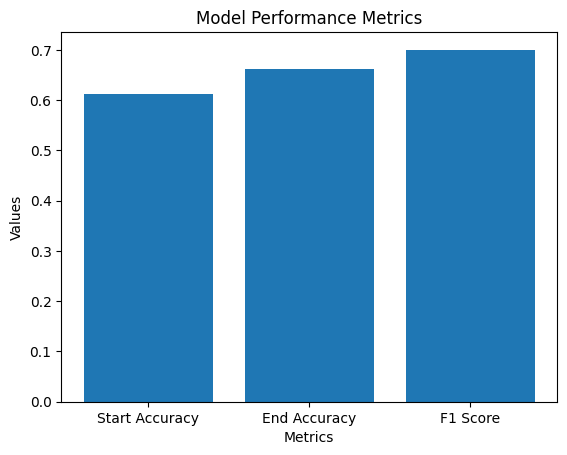

In [27]:
import matplotlib.pyplot as plt

# Example of plotting accuracy and F1 score
metrics = [start_accuracy, end_accuracy, f1_score]
labels = ['Start Accuracy', 'End Accuracy', 'F1 Score']

plt.bar(labels, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics')
plt.show()


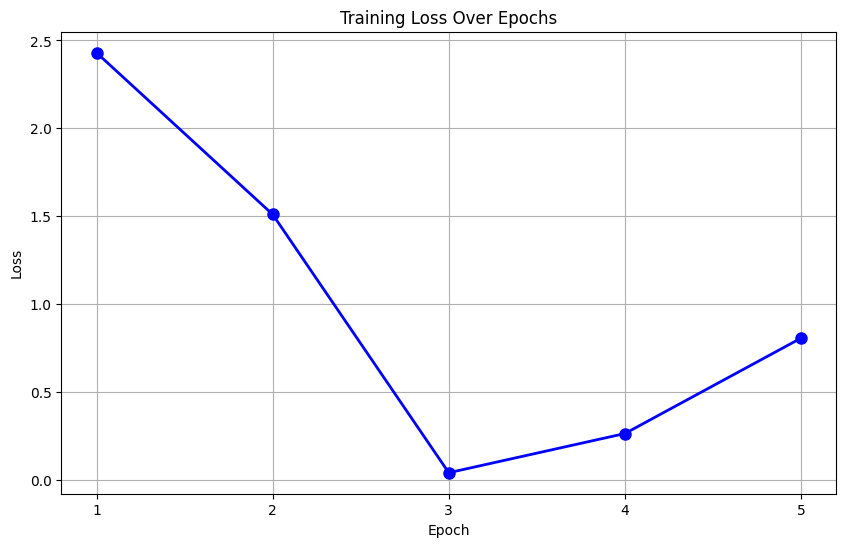

In [28]:
import matplotlib.pyplot as plt

# Data: Training loss values for each epoch
epochs = [1, 2, 3, 4, 5]
losses = [2.43, 1.51, 0.04, 0.263, 0.806]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()



In [30]:
import json
import random

def get_random_sample(file_path):
    with open(file_path, 'r') as file:
        squad_data = json.load(file)

    while True:
        # Select a random article
        article = random.choice(squad_data['data'])

        # Select a random paragraph from the article
        paragraph = random.choice(article['paragraphs'])

        # Select a random question-answer pair from the paragraph
        qa_pair = random.choice(paragraph['qas'])

        # Check if the answer exists
        if qa_pair['answers']:
            context = paragraph['context']
            question = qa_pair['question']
            answer = qa_pair['answers'][0]['text']  # Assuming we take the first answer
            return context, question, answer

# Specify the path to your SQuAD dataset file
file_path = 'train-v2.0.json'  # or 'dev-v2.0.json'

# Get a random sample
context, question, answer = get_random_sample(file_path)

print("Context:", context)
print("Question:", question)
print("Answer:", answer)


Context: Governments with strong tendencies towards kleptocracy can undermine food security even when harvests are good. Officials often steal state property. In Bihar, India, more than 80% of the subsidized food aid to poor is stolen by corrupt officials. Similarly, food aid is often robbed at gunpoint by governments, criminals, and warlords alike, and sold for a profit. The 20th century is full of many examples of governments undermining the food security of their own nations – sometimes intentionally.
Question: Even if a harvest is good, food security can be crippled when a government has tendencies toward what?
Answer: kleptocracy


In [33]:
def predict_answer(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

# Example context and question
context, question, answer = get_random_sample(file_path)


# Predict the answer
pred_answer = predict_answer(context, question)
print("Context:", context)
print("Question:", question)
print("Actual Answer:", answer)
print("Predicted Answer:", pred_answer)

Context: The cosmopolitan and multicultural nature of modern Guam poses challenges for Chamorros struggling to preserve their culture and identity amidst forces of acculturation. The increasing numbers of Chamorros, especially Chamorro youth, relocating to the U.S. Mainland has further complicated both definition and preservation of Chamorro identity.[citation needed] While only a few masters exist to continue traditional art forms, the resurgence of interest among the Chamorros to preserve the language and culture has resulted in a growing number of young Chamorros who seek to continue the ancient ways of the Chamorro people.
Question: What posses some challenges for the Chamorros who find it hard to keep their culture?
Actual Answer: cosmopolitan and multicultural nature of modern Guam
Predicted Answer: cosmopolitan and multicultural nature of modern guam poses challenges for chamorros struggling to preserve their culture and identity amidst forces of acculturation


Evaluating: 100%|██████████| 1269/1269 [05:52<00:00,  3.60batch/s]


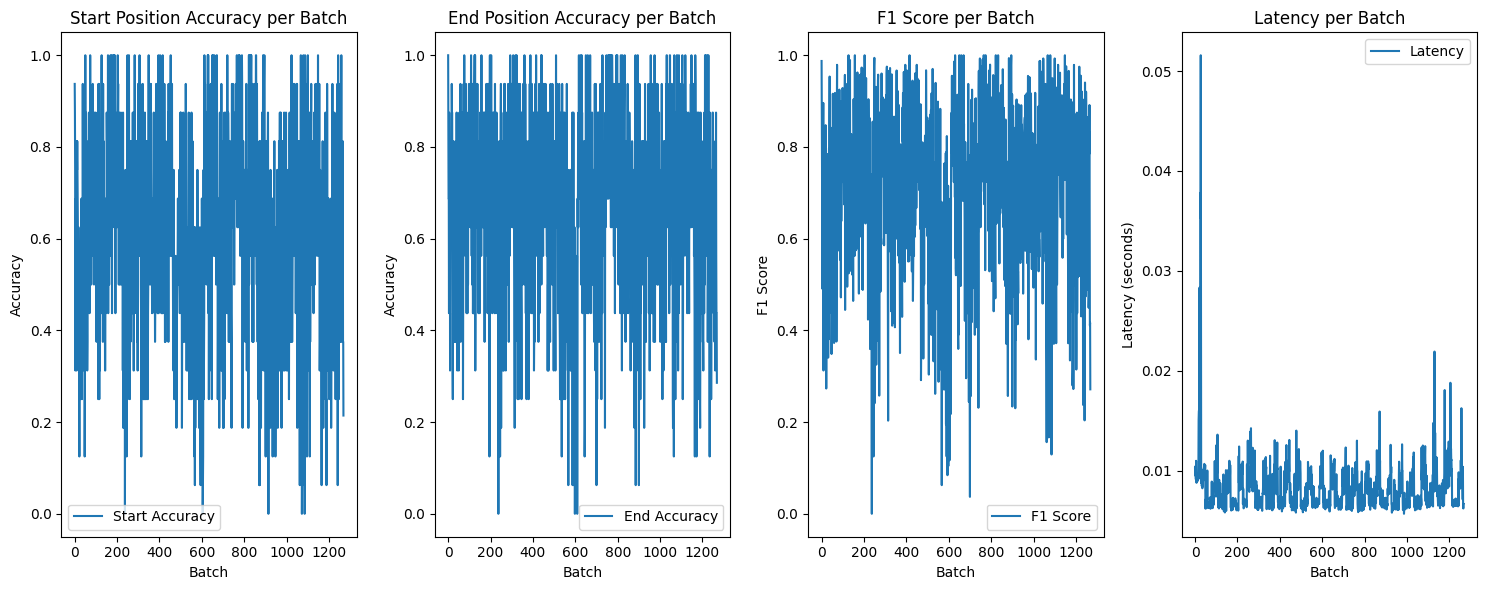

In [35]:


def evaluate_model(model, test_dataset, batch_size):
    model.eval()
    all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = [], [], [], []

    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            start_time = time.time()

            # Forward pass
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)

            # Measure latency
            latency = time.time() - start_time
            all_latencies.append(latency)

            # True positions
            start_positions_true = batch['answer_start_tokens'].to(device)
            end_positions_true = batch['answer_end_tokens'].to(device)

            # Predicted positions
            start_positions_pred = torch.argmax(outputs.start_logits, dim=1)
            end_positions_pred = torch.argmax(outputs.end_logits, dim=1)

            # Calculate accuracies
            start_accuracy = torch.mean((start_positions_pred == start_positions_true).float()).item()
            end_accuracy = torch.mean((end_positions_pred == end_positions_true).float()).item()
            all_start_accuracies.append(start_accuracy)
            all_end_accuracies.append(end_accuracy)

            # Calculate F1 scores
            f1_score_batch = calculate_f1_scores(start_positions_true.tolist(),
                                                 end_positions_true.tolist(),
                                                 start_positions_pred.tolist(),
                                                 end_positions_pred.tolist())
            all_f1_scores.append(f1_score_batch)

    return all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies

# Evaluate the model
all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = evaluate_model(model, test_dataset, batch_size=16)

# Plotting the metrics over batches
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.plot(all_start_accuracies, label='Start Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Start Position Accuracy per Batch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(all_end_accuracies, label='End Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('End Position Accuracy per Batch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(all_f1_scores, label='F1 Score')
plt.xlabel('Batch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Batch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(all_latencies, label='Latency')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
all_start_accuracies, all_end_accuracies, all_f1_scores, all_latencies = evaluate_model(model, test_dataset, batch_size=256)

Evaluating: 100%|██████████| 80/80 [05:32<00:00,  4.15s/batch]


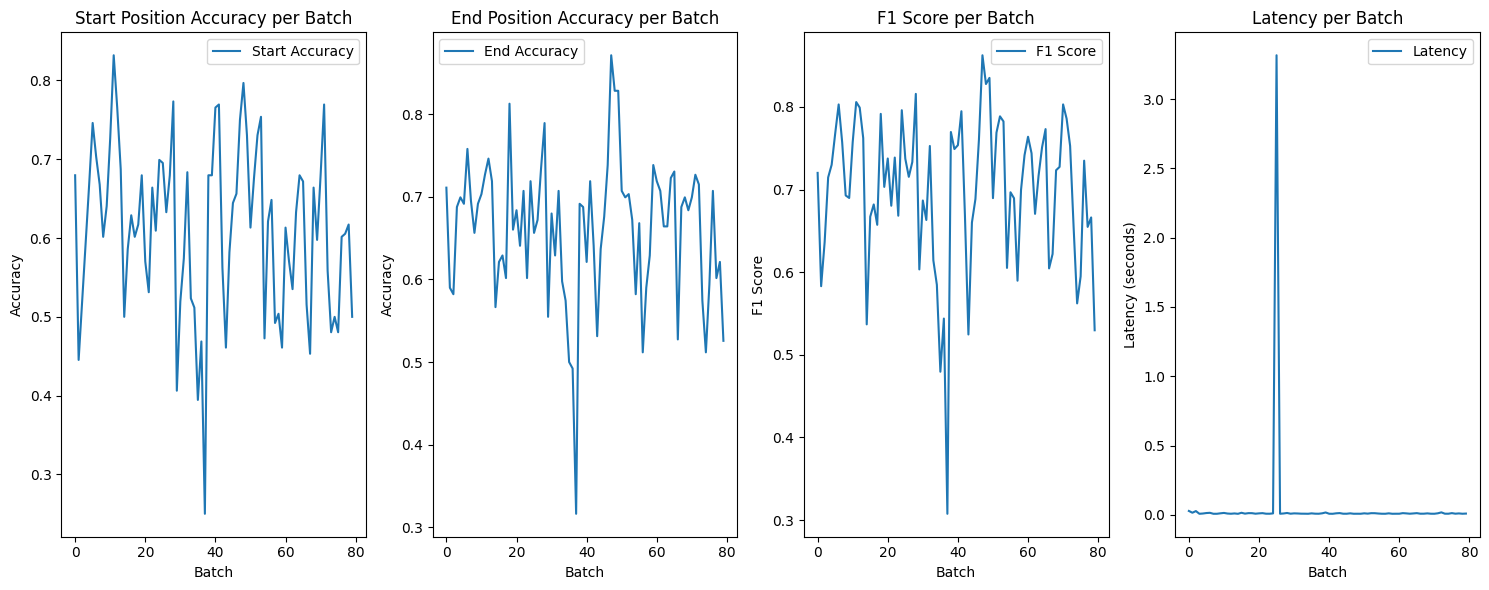

In [37]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.plot(all_start_accuracies, label='Start Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Start Position Accuracy per Batch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(all_end_accuracies, label='End Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('End Position Accuracy per Batch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(all_f1_scores, label='F1 Score')
plt.xlabel('Batch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Batch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(all_latencies, label='Latency')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()

plt.tight_layout()
plt.show()

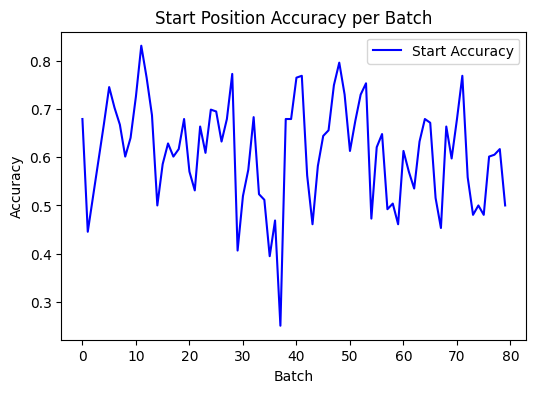

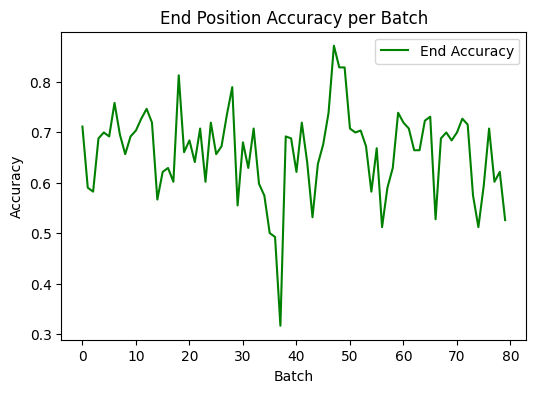

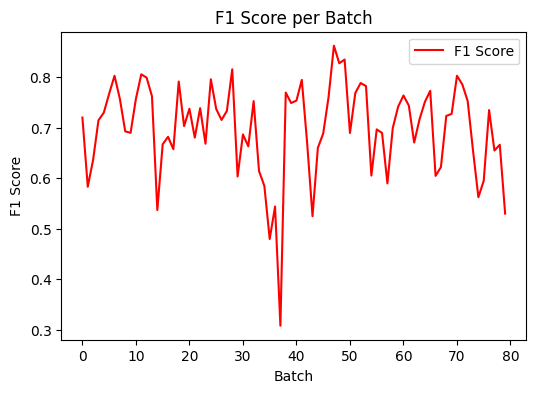

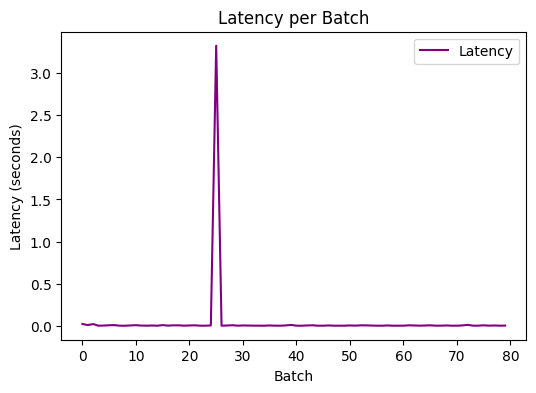

In [38]:
# Plotting each metric in separate figures

# Plotting Start Accuracy
plt.figure(figsize=(6, 4))
plt.plot(all_start_accuracies, label='Start Accuracy', color='blue')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Start Position Accuracy per Batch')
plt.legend()
plt.show()

# Plotting End Accuracy
plt.figure(figsize=(6, 4))
plt.plot(all_end_accuracies, label='End Accuracy', color='green')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('End Position Accuracy per Batch')
plt.legend()
plt.show()

# Plotting F1 Score
plt.figure(figsize=(6, 4))
plt.plot(all_f1_scores, label='F1 Score', color='red')
plt.xlabel('Batch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Batch')
plt.legend()
plt.show()

# Plotting Latency
plt.figure(figsize=(6, 4))
plt.plot(all_latencies, label='Latency', color='purple')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()
plt.show()



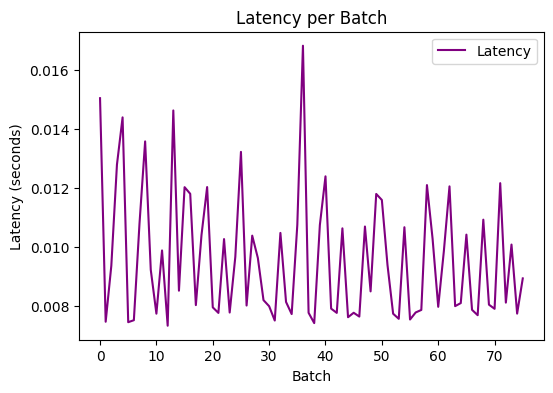

In [40]:
filtered_latencies = [lat for lat in all_latencies if lat < np.percentile(all_latencies, 95)]

# Plotting Latency without the outlier
plt.figure(figsize=(6, 4))
plt.plot(filtered_latencies, label='Latency', color='purple')
plt.xlabel('Batch')
plt.ylabel('Latency (seconds)')
plt.title('Latency per Batch')
plt.legend()
plt.show()

In [16]:
def load_squad_dataset(file_path):
    with open(file_path, 'r') as f:
        dataset = json.load(f)
    return dataset

squad_train_dataset = load_squad_dataset('train-v2.0.json')


In [17]:
def plot_length_distribution(data):
    context_lengths = []
    question_lengths = []
    answer_lengths = []

    for article in data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            context_lengths.append(len(context.split()))  # Tokenize context and count words

            for qa in paragraph['qas']:
                question = qa['question']
                question_lengths.append(len(question.split()))  # Tokenize question and count words

                # Add answer lengths if answers are available
                for answer in qa.get('answers', []):
                    answer_lengths.append(len(answer['text'].split()))

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(context_lengths, bins=50, color='blue', edgecolor='black')
    plt.title('Distribution of Context Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(question_lengths, bins=50, color='green', edgecolor='black')
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(answer_lengths, bins=50, color='red', edgecolor='black')
    plt.title('Distribution of Answer Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

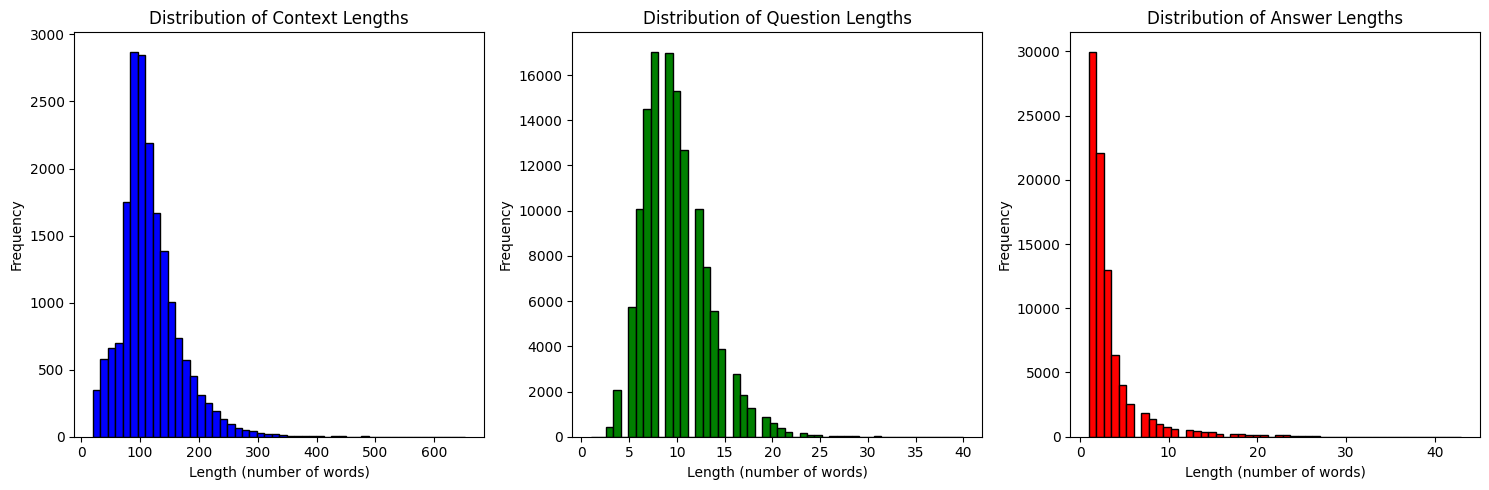

In [18]:
plot_length_distribution(squad_train_dataset)

In [19]:
print(model)

NameError: ignored